# Анализ картинок

Создайте эмбеддинги изображений и отобразите их в tensorboard projector'е

1. Скачайте датасет [CelebA](https://pytorch.org/vision/stable/datasets.html#celeba) или любой другой не рассмотренный на лекции
1. Выберите одну из предобученных [моделей torchvision](https://pytorch.org/vision/stable/models.html)
1. Создайте эмбеддинги изображений из датасета
1. Визуализируйте эмбеддинги в tensorboard projector

# Лена

Примените фильтр к изображению Лены

1. Скачайте изображение [Лены](http://optipng.sourceforge.net/pngtech/img/lena.png)
1. Найдите фильтр для выделения признака на изображении. В лекции показан пример фильтра Собеля. Использовать примеры с лекций нельзя. Начать поиск фильтра можно с [этой страницы](https://en.wikipedia.org/wiki/Feature_(computer_vision)#Extraction)
1. Реализуйте процедуру свёртки изображения с фильтром
1. Сверните Лену

In [1]:
from platform import python_version
import cv2
import torch
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import random
import scipy

import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from tqdm.notebook import tqdm, trange
import umap

In [2]:
print(f'Opencv version: {cv2.__version__}. \
        \nPython version: {python_version()}. \
        \nTorch version: {torch.__version__} \
        \nTorchvision version: {torchvision.__version__}')

Opencv version: 4.5.4.         
Python version: 3.8.1.         
Torch version: 1.10.0         
Torchvision version: 0.11.1


In [3]:
# Фиксируем random seed для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10  # Количество классов
EPOCH_NUM = 4  # Сколько эпох будет обучать модель

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
basic_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])  # Базовые аугментации для тренировочных данных (грубо говоря бесплатное увеличение тренировочной выборки)

In [5]:
# Загрузим данные

train_dataset = EMNIST(
    root='./data/EMNIST/train',
    split='digits',
    transform=basic_transform,
    download=True,
    train=True
)

test_dataset = EMNIST(
    root='./data/EMNIST/test',
    split='digits',
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ]),
    # Для тестовых данные НЕ НАДО использовать никакие аугментации
    download=True,
    train=False
)

In [6]:
# Создадим DataLoader'ы (для того чтобы было проще итерироваться)

print(type(train_dataset))

dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        # dataset=torch.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), 600, replace=False)),
        batch_size=256,
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        # dataset=torch.utils.data.Subset(test_dataset, np.random.choice(len(test_dataset), 600, replace=False)),
        batch_size=256,
        shuffle=False
    )
}

<class 'torchvision.datasets.mnist.EMNIST'>


In [7]:
# Создадим класс нашей модели

# Так как мы хотим использовать все фишки библиотеки Pytorch важно наследоваться от nn.Module
class EMNISTClassifier(nn.Module):
    def __init__(self, ouput_dim):
        super(EMNISTClassifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = resnet50(pretrained=True)  # Скачиваем пред-обученную основу для нашей модели

        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False

        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 128),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(128, ouput_dim)
        )

    def embed(self, x):
        return self.fc1(self.model(x))

    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [8]:
model = EMNISTClassifier(OUTPUT_DIM)
model = model.to(DEVICE)  # Переносим модель на GPU

In [9]:
# Создаем функцию ошибки (так как задача многоклассовой классификации, то используем кросс-энтропию)
# Более подробно об этом будет в курсе машинного обучения
loss_function = torch.nn.CrossEntropyLoss()

# Регистрируем для нашей модели способ изменения её весов
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [10]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

# Основной алгоритм обучения
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):

    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]

        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train()
        elif phase == 'val':
            model.eval()

        running_loss = 0.
        running_acc = 0.

        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            X_batch = X_batch / 255
            X_batch = transforms.Normalize(0.1307, 0.3081)(X_batch)

            # Переносим на устройство
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)

                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)

                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()

            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')

        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 1.7562 Acc: 0.4038 

Epoch: 1. Phase: val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 14.0632 Acc: 0.1551 

Epoch: 2. Phase: train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 1.5078 Acc: 0.4935 

Epoch: 2. Phase: val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 18.3303 Acc: 0.0508 

Epoch: 3. Phase: train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 1.4277 Acc: 0.5209 

Epoch: 3. Phase: val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 12.9521 Acc: 0.0813 

Epoch: 4. Phase: train:   0%|          | 0/938 [00:00<?, ?it/s]

train Loss: 1.3769 Acc: 0.5368 

Epoch: 4. Phase: val:   0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 17.5965 Acc: 0.0766 

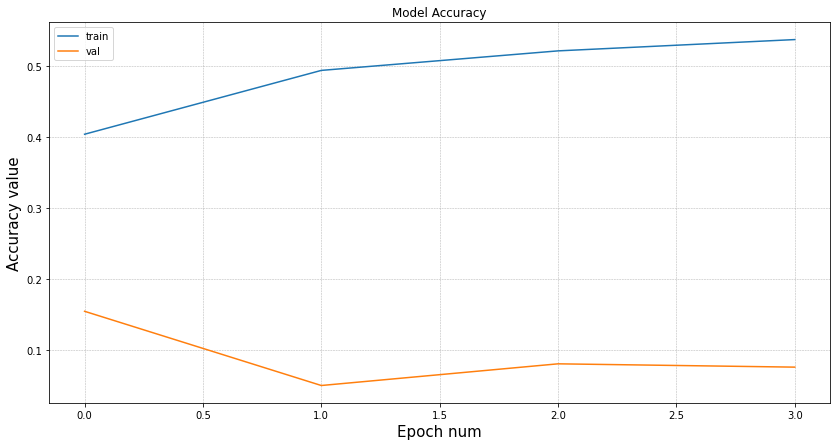

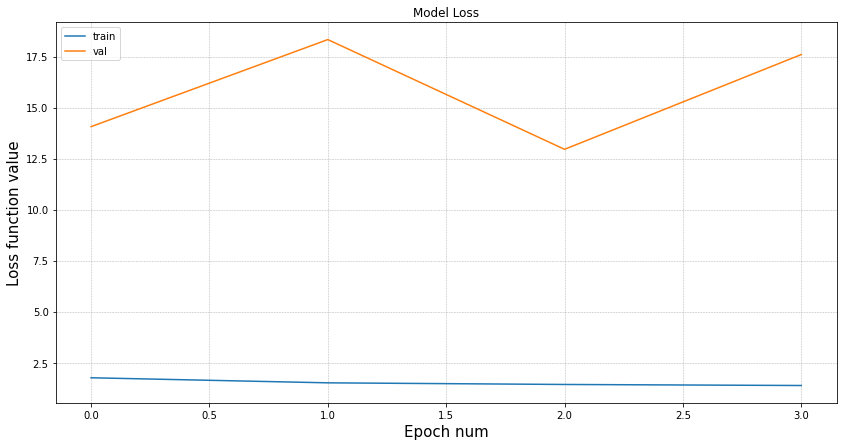

In [11]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

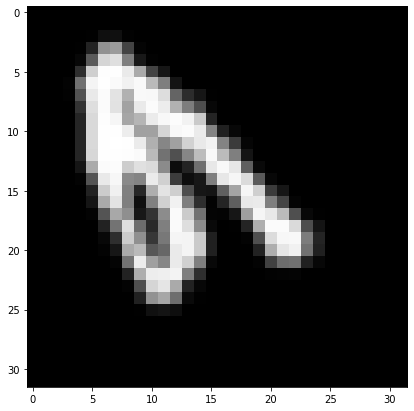

In [28]:
img = train_dataset[4][0].detach().numpy()

plt.imshow(np.transpose(img, (1,2,0)))

In [6]:
train_items = [train_dataset[i] for i in range(1000)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
xs = transforms.Normalize(0.1307, 0.3081)(xs)
xs.size()

NameError: name 'train_dataset' is not defined

In [14]:
embs = model.model(xs)
embs.size()

torch.Size([1000, 1000])

In [15]:
points = umap.UMAP().fit_transform(embs.detach().numpy())
points.shape

(1000, 2)

In [3]:
plt.figure(figsize=(14,12))
plt.scatter(points[:, 0], points[:, 1], c=ys,
            edgecolor='none', alpha=0.7, s=50,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

NameError: name 'plt' is not defined

In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [5]:
writer.add_embedding(embs,
                     metadata=ys,
                     label_img=xs)
writer.close()

NameError: name 'xs' is not defined

In [8]:
!tensorboard --logdir=runs --bind_all

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [39]:
!curl http://optipng.sourceforge.net/pngtech/img/lena.png --output pics/lena.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  462k  100  462k    0     0   326k      0  0:00:01  0:00:01 --:--:--  326k


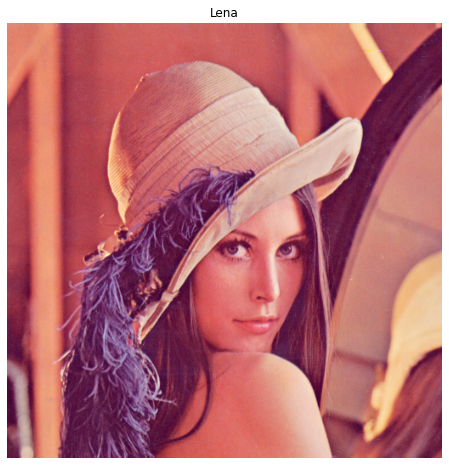

In [71]:
img_rgb = cv2.cvtColor(cv2.imread('pics/lena.png'), cv2.COLOR_BGR2RGB)  # Загрузка/чтение изображения

plt.figure(figsize=(15, 8))
plt.title('Lena')
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

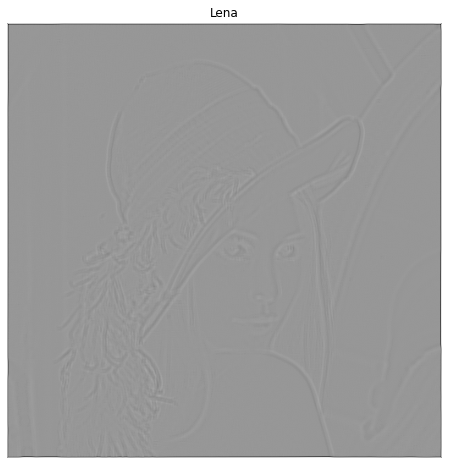

In [103]:
from scipy.signal import convolve2d

img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
img_gray_blur = cv2.blur(img_gray, ksize=(5, 5))
img_rgb_copy = img_rgb.copy()

kernel = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])

img_filter = convolve2d(img_gray_blur, kernel)

plt.figure(figsize=(15, 8))
plt.title('Lena')
plt.imshow(img_filter, cmap='gray')
plt.axis('off')
plt.show()

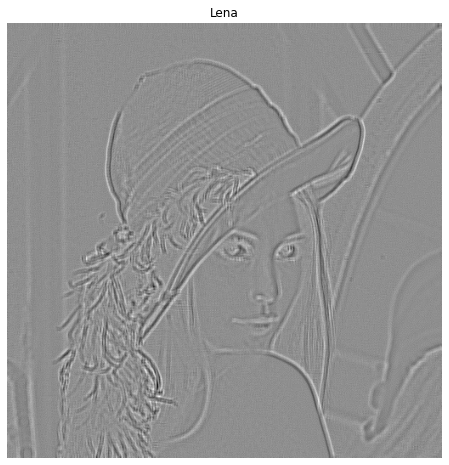

In [97]:
laplacian = cv2.Laplacian(img_gray_blur, cv2.CV_64FC4)

plt.figure(figsize=(15, 8))
plt.title('Lena')
plt.imshow(laplacian, cmap='gray')
plt.axis('off')
plt.show()